Loading and preprocessing healthy images...
Loaded 75 healthy images
Loading and preprocessing redrot images...
Loaded 74 redrot images
Training quantum classifier...


C:\Users\Yashvitha PR\AppData\Roaming\Python\Python311\site-packages\pennylane\_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 1/20, Loss: 0.9678
Epoch 6/20, Loss: 0.9678
Epoch 11/20, Loss: 0.9678
Epoch 16/20, Loss: 0.9678
Epoch 20/20, Loss: 0.9678
Test accuracy: 0.6000

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.25      0.40        16
      RedRot       0.54      1.00      0.70        14

    accuracy                           0.60        30
   macro avg       0.77      0.62      0.55        30
weighted avg       0.78      0.60      0.54        30



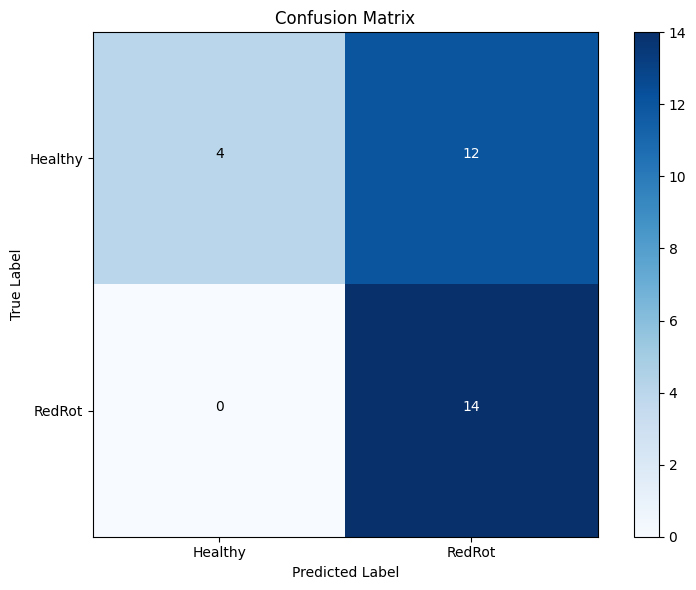

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pennylane as qml
from pennylane import numpy as qnp
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(42)
torch.manual_seed(42)

healthy_dir = r"C:\Users\Yashvitha PR\Downloads\Sugarcane-Leaf-Disease-Detection-main\Sugarcane-Leaf-Disease-Detection-main\dataset\Healthy"
redrot_dir = r"C:\Users\Yashvitha PR\Downloads\Sugarcane-Leaf-Disease-Detection-main\Sugarcane-Leaf-Disease-Detection-main\dataset\RedRot"

def preprocess_images(directory, label, img_size=(32, 32)):
    images = []
    labels = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                
                img_array = np.array(img) / 255.0
                
                # Convert to grayscale and flatten (simplification for QML)
                img_gray = np.mean(img_array, axis=2)
                
                # Further dimensionality reduction through average pooling
                img_reduced = img_gray.reshape(4, img_size[0]//4, 4, img_size[1]//4).mean(axis=(1, 3))
                
                # Flatten to 1D array
                img_flat = img_reduced.flatten()
                
                images.append(img_flat)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    return np.array(images), np.array(labels)

print("Loading and preprocessing healthy images...")
healthy_images, healthy_labels = preprocess_images(healthy_dir, 0)
print(f"Loaded {len(healthy_images)} healthy images")

print("Loading and preprocessing redrot images...")
redrot_images, redrot_labels = preprocess_images(redrot_dir, 1)
print(f"Loaded {len(redrot_images)} redrot images")

X = np.vstack((healthy_images, redrot_images))
y = np.hstack((healthy_labels, redrot_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_qubits = 4  # Using 4 qubits for our circuit
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode input data
    for i in range(n_qubits):
        qml.RY(np.pi * inputs[i], wires=i)
    
    # Entangling layers
    for layer in range(2):  # 2 layers of entanglement
        # Rotation gates with weights
        for i in range(n_qubits):
            qml.RX(weights[layer, i, 0], wires=i)
            qml.RY(weights[layer, i, 1], wires=i)
            qml.RZ(weights[layer, i, 2], wires=i)
        
        # Entanglement
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])
        qml.CNOT(wires=[n_qubits-1, 0])  # Connect last qubit to first
    
    # Measurement
    return qml.expval(qml.PauliZ(0))

class QuantumClassifier:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.weights = np.random.uniform(
            low=0, high=2*np.pi, 
            size=(2, n_qubits, 3) 
        )
        self.opt = qml.GradientDescentOptimizer(stepsize=0.1)
    
    def preprocess_input(self, x):
        return x / np.max(np.abs(x))
    
    def predict(self, X):
        predictions = []
        for x in X:
            # Select first n_qubits features (dimension reduction)
            x_red = self.preprocess_input(x[:self.n_qubits])
            pred = quantum_circuit(x_red, self.weights)
            predictions.append(1 if pred > 0 else 0)
        return np.array(predictions)
    
    def train_step(self, X_batch, y_batch):
        def loss_fn(weights):
            loss = 0
            for x, y in zip(X_batch, y_batch):
                x_red = self.preprocess_input(x[:self.n_qubits])
                pred = quantum_circuit(x_red, weights)
                # Convert target to expectation value: -1 for class 0, +1 for class 1
                target = 2 * y - 1
                # Loss increases when prediction and target have opposite signs
                loss += (pred - target) ** 2
            return loss / len(X_batch)
        
        # Update weights using gradient descent
        self.weights = self.opt.step(loss_fn, self.weights)
        
        # Calculate current loss
        return loss_fn(self.weights)
    
    def train(self, X, y, batch_size=10, epochs=20):
        n_samples = len(X)
        losses = []
        
        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                batch_loss = self.train_step(X_batch, y_batch)
                epoch_loss += batch_loss * len(X_batch)
            
            avg_loss = epoch_loss / n_samples
            losses.append(avg_loss)
            
            if epoch % 5 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
        return losses

print("Training quantum classifier...")
qc = QuantumClassifier(n_qubits=n_qubits)
losses = qc.train(X_train, y_train, batch_size=5, epochs=20)

y_pred = qc.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Healthy', 'RedRot']))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Healthy', 'RedRot'])
plt.yticks(tick_marks, ['Healthy', 'RedRot'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

def predict_image(image_path, model, img_size=(32, 32)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    
    img_array = np.array(img) / 255.0
    
    img_gray = np.mean(img_array, axis=2)
    
    img_reduced = img_gray.reshape(4, img_size[0]//4, 4, img_size[1]//4).mean(axis=(1, 3))
    
    img_flat = img_reduced.flatten()
    
    prediction = model.predict(np.array([img_flat]))[0]
    label = "RedRot" if prediction == 1 else "Healthy"
    
    return label, prediction




Prediction: RedRot (score: 1.0000)


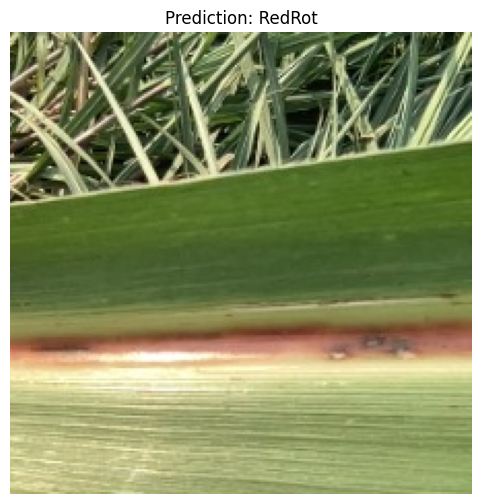

In [3]:
test_image_path = "C:\\Users\\Yashvitha PR\\Downloads\\Sugarcane-Leaf-Disease-Detection-main\\Sugarcane-Leaf-Disease-Detection-main\\dataset\\RedRot\\0.jpg"

label, pred = predict_image(test_image_path, qc)
print(f"Prediction: {label} (score: {pred:.4f})")

plt.figure(figsize=(6, 6))
plt.imshow(Image.open(test_image_path))
plt.title(f"Prediction: {label}")
plt.axis('off')
plt.show()